In [10]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from core import junction_potential
from graphics import simple_axes, adjust_raster_ticks, add_scalebar, hide_axes, offset_traces

In [11]:
def load_abf(pprox):
    """Reads the ABF file associated with an epoch """
    import nbank as nb
    from neo.io import AxonIO
    registry_url, resource_id = nb.parse_resource_id(pprox["source"])
    resource_path = nb.get(resource_id, registry_url, local_only=True)
    abf_path = (Path(resource_path) / pprox["abf_file"]).with_suffix(".abf")
    ifp = AxonIO(abf_path)
    return ifp.read_block(lazy=True)


In [12]:
base = Path("../build")
iv_stats = pd.read_csv(base / "iv_stats.csv", index_col=["cell", "epoch", "sweep"])
sweep_stats = pd.read_csv(base / "sweep_stats.csv", index_col=["cell", "epoch", "sweep"])
epoch_stats = pd.read_csv(base / "epoch_stats.csv", index_col=["cell", "epoch"])

In [13]:
# phasic stable
cell = "328b1402"
epoch_idx = [3, 4, 5, 6, 7]
sweep_idx = [10, 14, 17]

In [14]:
# tonic plastic
cell = "2d21b861"
epoch_idx = [3, 4, 5, 6, 7, 8]
sweep_idx = [10, 14, 17]

In [73]:
# tonic stable - PR
cell = "8486a193"
epoch_idx = [2, 3, 4, 5, 6, 7]
sweep_idx = [10, 14, 18]

In [78]:
# tonic stable - PR
cell = "0e40048d"
epoch_idx = [13, 14, 15, 17, 18, 19, 20]
sweep_idx = [10, 14, 18]

In [79]:
epochs = epoch_stats.loc[cell].loc[epoch_idx]
sweeps = sweep_stats.loc[cell].loc[epoch_idx]
steps = iv_stats.loc[cell].loc[epoch_idx]

In [80]:
bin_size = 10
floor = np.floor(steps.current.min() / bin_size) * bin_size
ceil  = np.ceil(steps.current.max() / bin_size) * bin_size
bins = np.arange(floor, ceil + bin_size, bin_size)
steps_binned = steps.groupby(["epoch", pd.cut(steps.current, bins, labels=False)]).mean()

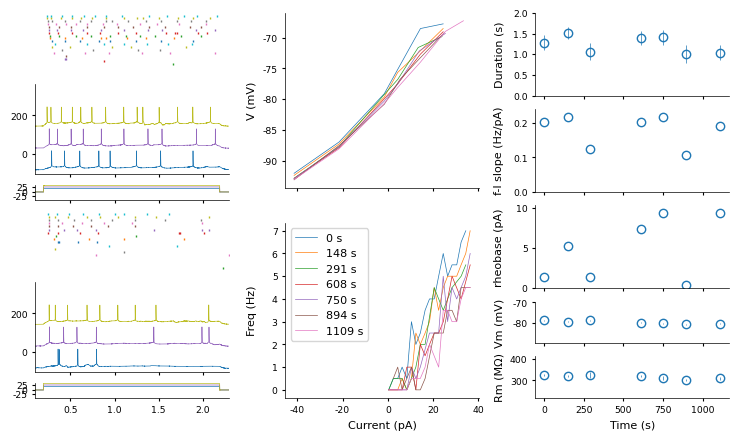

In [81]:
fig = plt.figure(figsize=(7.5, 5))
subfigs = fig.subfigures(1, 3, wspace=0.02)

axes = subfigs[1].subplots(2, sharex=True)
for enumber, epoch in steps_binned.groupby("epoch"):
    axes[0].plot(epoch.current, epoch.voltage, label="%d s" % int(epochs.loc[enumber].time))
axes[0].set_ylabel("V (mV)")
for enumber, epoch in sweeps.groupby("epoch"):
    axes[1].plot(epoch.current, epoch.firing_rate, label="%d s" % int(epochs.loc[enumber].time))
axes[1].set_ylabel("Freq (Hz)")
axes[1].set_xlabel("Current (pA)")
axes[1].legend()
simple_axes(*axes)
subfigs[1].align_ylabels(axes)

marker_style = {"marker": 'o', "linestyle": 'none', "fillstyle": "none"}
axes = subfigs[2].subplots(5, sharex=True, height_ratios=(2, 2, 2, 1, 1))
axes[0].errorbar(epochs.time, epochs.duration_mean, epochs.duration_sd / np.sqrt(epochs.n_spike_sweeps), **marker_style)
axes[0].set_ylim(0, 2.0)
axes[0].set_ylabel("Duration (s)")
axes[1].plot(epochs.time, epochs.slope, **marker_style)
axes[1].set_ylim(0, epochs.slope.max() * 1.1)
axes[1].set_ylabel("f-I slope (Hz/pA)")
axes[2].plot(epochs.time, epochs.rheobase, **marker_style)
axes[2].set_ylim(0, epochs.rheobase.max() * 1.1)
axes[2].set_ylabel("rheobase (pA)")
axes[3].errorbar(epochs.time, epochs.Vm, epochs.Vm_sd / np.sqrt(epochs.n_sweeps), **marker_style)
axes[3].set_ylim(epochs.Vm.mean() - 10, epochs.Vm.mean() + 10)
axes[3].set_ylabel("Vm (mV)")                  
axes[4].errorbar(epochs.time, epochs.Rm, epochs.Rm_sd / np.sqrt(epochs.n_sweeps), **marker_style)
Rmm = epochs.Rm.mean()
axes[4].set_ylim(Rmm * 0.7, Rmm * 1.3)
axes[4].set_ylabel("Rm (MΩ)")
axes[4].set_xlabel("Time (s)")
simple_axes(*axes)
#subfigs[2].subplots_adjust(hspace=0.08)
subfigs[2].align_ylabels(axes)

axes = subfigs[0].subplots(6, sharex=True, height_ratios=(2, 3, 0.5, 2, 3, 0.5))
aidx = 0
for eidx in [epoch_idx[0], epoch_idx[-1]]:
    s_ax = axes[aidx + 0]
    v_ax = axes[aidx + 1]
    i_ax = axes[aidx + 2]
    pprox = base / "{}_{:02}.pprox".format(cell, eidx)
    with open(pprox, "rt") as fp:
        epoch = json.load(fp)
    for idx, pproc in enumerate(epoch["pprox"]):
        s_ax.plot(pproc["events"], [idx] * len(pproc["events"]), '|')
    adjust_raster_ticks(s_ax, gap=2)

    block = load_abf(epoch)
    for sidx in sweep_idx:
        segment = block.segments[sidx]
        V = (
            (segment.analogsignals[0].load() - junction_potential)
            .rescale("mV")
        )
        I = (
            segment.analogsignals[1]
            .load()
            .rescale("pA")
        )
        color = s_ax.lines[sidx].get_color()
        t = V.times - V.t_start
        v_ax.plot(t, V.magnitude, color=color)
        i_ax.plot(t, I, color=color)
    offset_traces(v_ax)
    aidx += 3
hide_axes(axes[0], axes[3])
simple_axes(axes[1], axes[2], axes[4], axes[5])
axes[0].set_xlim(0.1, 2.3);

In [77]:
fig.savefig(f"../figures/{cell}_plasticity.pdf")

In [72]:
epochs

,n_sweeps,n_spike_sweeps,duration_max,duration_mean,duration_sd,rate_max,rheobase,slope,Rs,Rs_sd,...,Vm_sd,temperature,spike_width,spike_trough,tau,Cm,time,delta_Rs,delta_Rm,delta_Vm
epoch,,,,,,,,,,,,,,,,,,,,,
2,20.0,10.0,1.91136,1.733411,0.167528,8.0,40.354753,0.223469,19.865285,3.146962,...,0.848426,28.350080,1.486667,53.071111,41.664538,131.544590,0.000000,0.000000,0.000000,0.000000
3,20.0,10.0,1.94154,1.709182,0.295721,9.5,40.371254,0.266439,19.598771,3.160954,...,2.697307,28.763157,1.488889,42.613333,46.940832,119.075612,136.822000,-0.013416,0.228592,0.008856
4,20.0,13.0,1.93492,1.655680,0.512576,13.5,35.934355,0.224612,20.161985,5.293390,...,1.898664,28.453873,1.760000,44.871667,NaN,NaN,428.743001,0.014936,0.168938,0.001785
5,20.0,13.0,1.88952,1.541942,0.556448,8.0,28.437155,0.168142,22.378412,7.157999,...,0.937208,28.230109,1.841818,49.421818,60.820788,148.296263,578.688000,0.126508,0.262410,0.017987
6,20.0,8.0,1.91258,1.692651,0.192614,7.5,48.466101,0.263324,22.626486,3.981304,...,1.421258,28.089347,1.834286,49.882857,47.263287,138.309691,739.041000,0.138996,0.184470,-0.005335
7,20.0,7.0,1.88692,1.764510,0.100463,7.0,52.460758,0.292891,25.428460,4.239264,...,1.268984,28.225769,1.860000,40.476667,35.676338,106.664815,1001.996000,0.280045,0.072577,-0.026441
8,19.0,6.0,1.89484,1.782860,0.078675,6.5,56.457148,0.321903,27.152119,4.727703,...,1.483158,28.670844,2.004000,39.720000,35.867464,122.290213,1261.762001,0.366812,0.026363,-0.015447
